<a href="https://colab.research.google.com/github/marwanhaqiqi/amazon-review-analysis/blob/main/amazon_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [7]:
# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set_theme(style="whitegrid")

In [8]:
# Load Data
df = pd.read_csv("/content/sample_data/amazon_review.csv")

In [9]:
# Data Preparation
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
current_date = df['reviewTime'].max() + pd.Timedelta(days=2)
df['days_since_review'] = (current_date - df['reviewTime']).dt.days

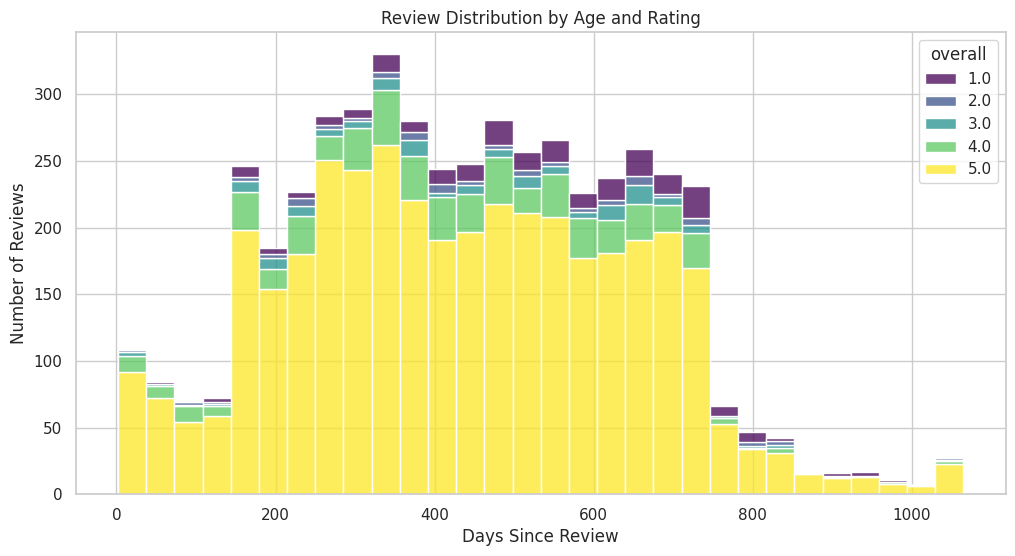

In [10]:
# Visualization 1: Rating Distribution Over Time
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='days_since_review', hue='overall',
             palette='viridis', bins=30, multiple='stack')
plt.title('Review Distribution by Age and Rating')
plt.xlabel('Days Since Review')
plt.ylabel('Number of Reviews')
plt.show()

In [11]:
# Simple and Time-Weighted Average Calculation
def calculate_time_weighted_rating(df):
    time_weights = {
        '0-250 days': {'max_days': 250, 'weight': 0.28},
        '251-550 days': {'max_days': 550, 'weight': 0.26},
        '551-800 days': {'max_days': 800, 'weight': 0.24},
        '800+ days': {'weight': 0.22}
    }

    weighted_sum = 0
    for period, params in time_weights.items():
        if period == '800+ days':
            mask = df['days_since_review'] > 800
        else:
            mask = df['days_since_review'] <= params['max_days']

        period_avg = df.loc[mask, 'overall'].mean()
        weighted_sum += period_avg * params['weight']

    return weighted_sum

time_weighted_avg = calculate_time_weighted_rating(df)
simple_avg = df['overall'].mean()

print(f"Simple Average: {simple_avg:.2f}")
print(f"Time-Weighted Average: {time_weighted_avg:.2f}")

Simple Average: 4.59
Time-Weighted Average: 4.58


In [12]:
# Helpfulness Analysis
df['helpful_no'] = df['total_vote'] - df['helpful_yes']

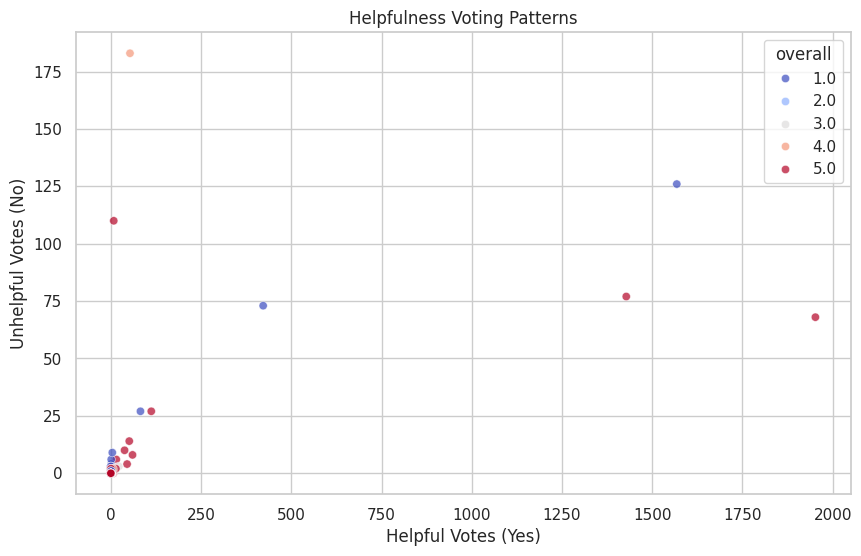

In [18]:
# Visualization 2: Helpful Votes Distribution
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='helpful_yes', y='helpful_no',
                hue='overall', palette='coolwarm', alpha=0.7)
plt.title('Helpfulness Voting Patterns')
plt.xlabel('Helpful Votes (Yes)')
plt.ylabel('Unhelpful Votes (No)')
plt.show()

In [14]:
# Wilson Lower Bound Calculation
def wilson_lower_bound(up, down, confidence=0.95):
    n = up + down
    if n == 0: return 0
    z = stats.norm.ppf(1 - (1 - confidence)/2)
    phat = up/n
    return (phat + z*z/(2*n) - z*math.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n)

df['wilson_score'] = df.apply(lambda x: wilson_lower_bound(x['helpful_yes'], x['helpful_no']), axis=1)

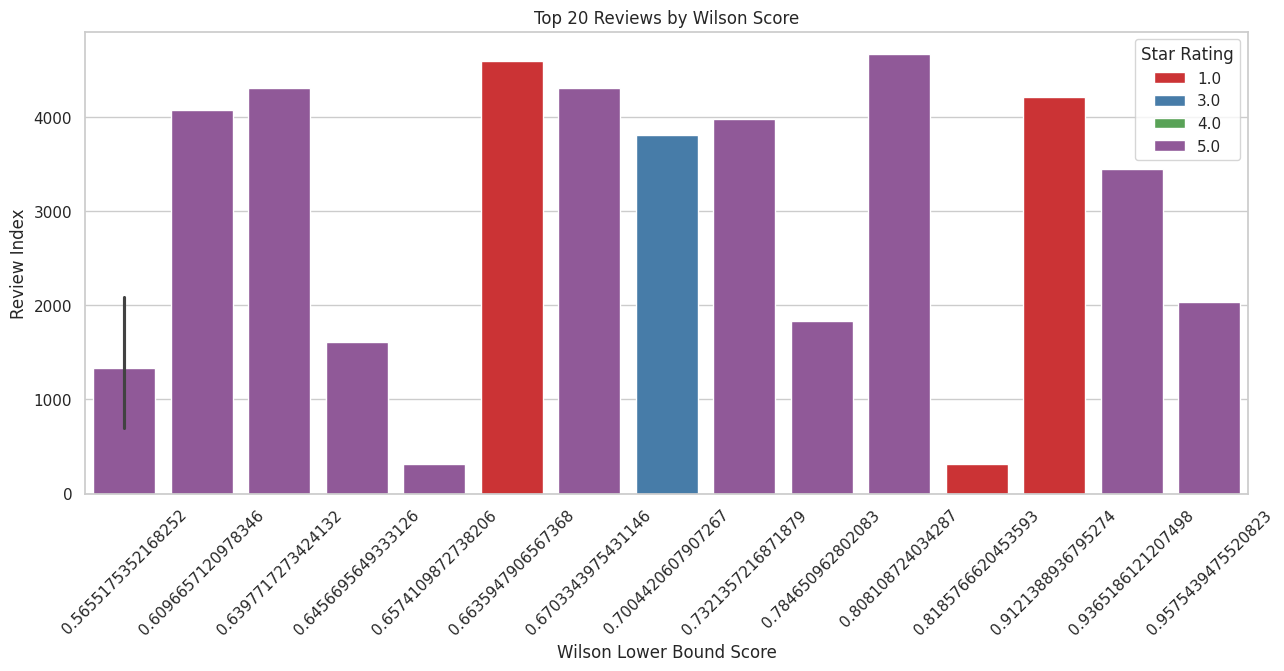

In [15]:
# Visualization 3: Top Reviews Analysis
top_reviews = df.sort_values("wilson_score", ascending=False).head(20)
plt.figure(figsize=(15,6))
sns.barplot(data=top_reviews, x='wilson_score', y=top_reviews.index,
           hue='overall', palette='Set1', dodge=False)
plt.title('Top 20 Reviews by Wilson Score')
plt.xlabel('Wilson Lower Bound Score')
plt.xticks(rotation=45)
plt.ylabel('Review Index')
plt.legend(title='Star Rating')
plt.show()

In [16]:
summary_table = pd.DataFrame({
    'Metric': ['Simple Average', 'Time-Weighted Average',
               'Top Review Wilson Score', 'Avg Helpful Votes'],
    'Value': [simple_avg, time_weighted_avg,
             top_reviews['wilson_score'].mean(),
             df['helpful_yes'].mean()]
})

display(summary_table.style.background_gradient(cmap='Blues'))

,Metric,Value
0,Simple Average,4.587589
1,Time-Weighted Average,4.584317
2,Top Review Wilson Score,0.700491
3,Avg Helpful Votes,1.311089


In [17]:
# Top 20 review sorting by Wilson Bound Score
top_reviews

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days_since_review,helpful_no,wilson_score
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,703,68,0.95754
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.00000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,804,77,0.93652
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.00000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,580,126,0.91214
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.00000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1034,73,0.81858
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.00000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,159,4,0.80811
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.00000,I own it,1393545600,2014-02-28,283,60,68,284,8,0.78465
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.00000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,778,27,0.73214
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.00000,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,650,3,0.70044
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.00000,Awesome Card!,1339200000,2012-09-06,823,51,65,824,14,0.67033
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.00000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,808,27,0.66359
